# Проект "Принятие решений в бизнесе на основе данных"

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Часть 1. Приоритизация гипотез.


В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

In [103]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


## <font color='green'>Фреймворк ICE</font>

In [104]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

print((hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)).round(2))

                                          hypothesis    ICE
8  Запустить акцию, дающую скидку на товар в день...  16.20
0  Добавить два новых канала привлечения трафика,...  13.33
7  Добавить форму подписки на все основные страни...  11.20
6  Показать на главной странице баннеры с актуаль...   8.00
2  Добавить блоки рекомендаций товаров на сайт ин...   7.00
1  Запустить собственную службу доставки, что сок...   2.00
5  Добавить страницу отзывов клиентов о магазине,...   1.33
3  Изменить структура категорий, что увеличит кон...   1.12
4  Изменить цвет фона главной страницы, чтобы уве...   1.00


##  <font color='green'>Фреймворк RICE</font>

In [105]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

print(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                          hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


## Вывод: 
При применении ICE наиболее перспективные гипотезы 8, 0, 7 и 6, а RICE показывает, что на первом месте уже гипотеза 7, потом 2,0 и 6. Это произошло потому что параметр охвата у гипотезы 7 намного выше. То есть эти изменения затронут большее количество пользователей.

<font color='blue'> Хорошо, показатели рассчитаны верно, выводы точны. </font>

# Часть 2. Анализ A/B-теста


Результаты A/B-теста описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

In [106]:
orders = pd.read_csv('/datasets/orders.csv')
orders.columns = orders.columns.str.lower()
orders.head(3)
#orders.info()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [107]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head(3)
#visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


## <font color='green'>Куммулятивная выручка</font>

In [108]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# Получим строки orders, дата которых <= дате элемента из datesGroups, а группа теста равна группе из datesGroups
# Агрегируем значения, найдём число уникальных ID заказов и пользователей
# Подсчитаем сумму средних чеков

ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
)

# Получим нужные строки visitors, агрегируем значения
# Посчитаем количество пользователей

visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cummulativeData.head(5))

         date group  orders  buyers  revenue  visitors
0  2019-08-01     A      24      20   148579       719
1  2019-08-01     B      21      20   101217       713
2  2019-08-02     A      44      38   242401      1338
3  2019-08-02     B      45      43   266748      1294
4  2019-08-03     A      68      62   354874      1845


__Построим график выручки группы A и группы B__

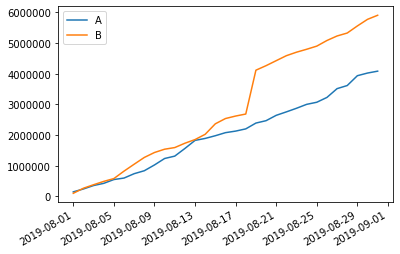

In [109]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и B
cummulativeRevenueA = cummulativeData[cummulativeData['group']=='A'][['date','revenue', 'orders']]
cummulativeRevenueB = cummulativeData[cummulativeData['group']=='B'][['date','revenue', 'orders']]


cummulativeRevenueA['date'] = pd.to_datetime(cummulativeRevenueA['date'], format='%Y-%m-%d')
cummulativeRevenueB['date'] = pd.to_datetime(cummulativeRevenueB['date'], format='%Y-%m-%d')


# Строим график выручки группы А и B

fig = plt.figure()
#fig, ax = plt.subplots()
#xticks(range(31))

plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')

fig.autofmt_xdate()

plt.legend()

Выручка увеличивается в течение всего теста, но график выручки группы B в одной точке резко растет. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.

## <font color='green'>Куммулятивный средний чек</font>

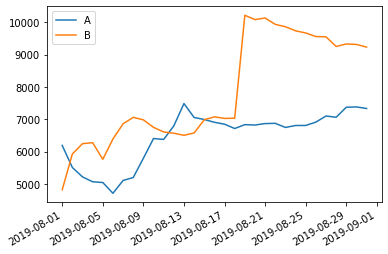

In [110]:
fig = plt.figure()
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue']/cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue']/cummulativeRevenueB['orders'], label='B')
fig.autofmt_xdate()
plt.legend()

Средний чек становится более равномерным к концу теста: немного растет для группы A и  и продолжает падать для группы B. Возможно, в группу B в середине теста попали крупные заказы (резкий всплеск на графике). 

## <font color='green'>Относительное изменение кумулятивного среднего чека группы B к группе A</font>

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline():

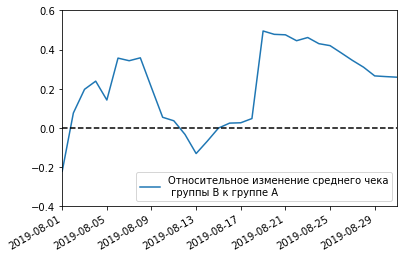

In [111]:
fig = plt.figure()
# собираем данные в одном датафрейме
mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB'])/(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1, label="Относительное изменение среднего чека\n группы B к группе A")
plt.legend(loc='lower right')
fig.autofmt_xdate()
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.4, 0.6])
plt.show()

График различия между сегментами резко «скачет». Сначала средний чек группы B стабильно растет, потом резко падает и резко взлетает. Возможно это влияние крупных заказов и выбросов. Все три графика демонстрируют одинаковую картину.

## <font color='green'>Кумулятивная конверсия</font>

Аналогично проанализируем график кумулятивной конверсии. Зададим масштаб осей методом plt.axis().

In [112]:
# считаем кумулятивную конверсию
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']
print(cummulativeData['conversion'].min())
print(cummulativeData['conversion'].max())

0.029217427214536445
0.03685636856368564


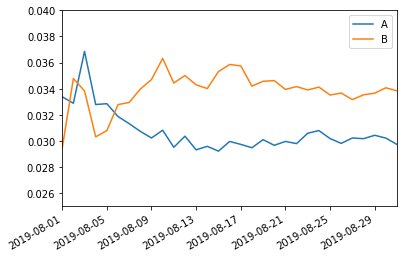

In [113]:
cummulativeData['date'] = pd.to_datetime(cummulativeData['date'], format='%Y-%m-%d')

# отделяем данные по группе A и B
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']


# строим графики
fig = plt.figure()
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
fig.autofmt_xdate()
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.040])
plt.show()

Группы колебались около одного значения, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась.

##  <font color='green'>Относительное изменение кумулятивной конверсии группы B к группе A</font>

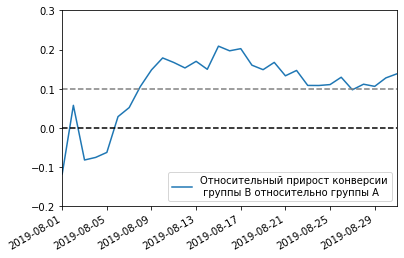

In [114]:
mergedCummulativeConversions = cummulativeDataA[['date','conversion']].merge(cummulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig = plt.figure()
plt.plot(mergedCummulativeConversions['date'], mergedCummulativeConversions['conversionB']/mergedCummulativeConversions['conversionA']-1, label="Относительный прирост конверсии\n группы B относительно группы A")
plt.legend(loc="lower right")
fig.autofmt_xdate()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.3])

plt.show()

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Конверсия группы B стабильно выше.
Стоит проанализировать аномалии, возможно результаты изменятся.

## <font color='green'>Точечный график количества заказов по пользователям</font>

Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [115]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})

ordersByUsers.columns = ['visitorid','orders']

print(ordersByUsers.sort_values(by='orders',ascending=False).head(10))

       visitorid  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Построим гистрограмму распределения количества заказов на одного пользователя.

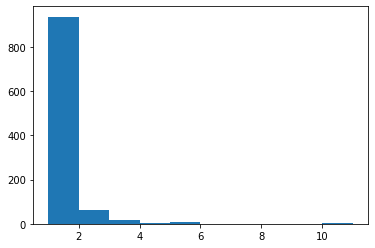

In [116]:
plt.hist(ordersByUsers['orders'])
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна.
Построим точечную диаграмму числа заказов на одного пользователя:

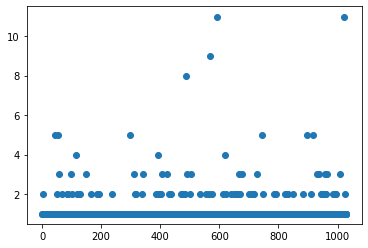

In [117]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

Выводы подтверждаются: есть пользователи с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

## <font color='green'>95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей.</font>

In [118]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше чем 2 заказа.

Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

## <font color='green'>Точечный график стоимостей заказов</font>

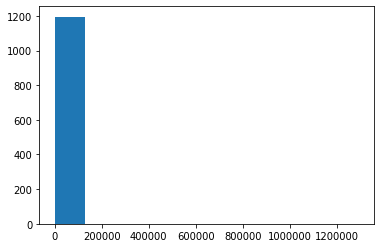

In [119]:
plt.hist(orders['revenue'])
plt.show()

In [120]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Три четверти стоимостей заказов находятся в пределах 10000.

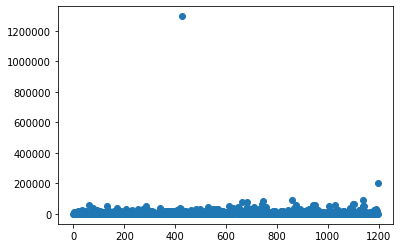

In [121]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

Практически все стоимости заказов находятся в пределах 100000, но есть выброс со стоимостями более миллиона. Именно этот заказ отразился на всех графиках.

## <font color='green'>95-й и 99-й перцентили стоимости заказов.  Граница для определения аномальных заказов.</font>

In [122]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Менее 5% заказов стоят дороже 28000, можно взять эту цифру за границу для определения аномальных заказов

## <font color='green'>Cтатистическая значимость различий в конверсии между группами по «сырым» данным</font>

In [123]:
# Считаем количество пользователей до выбранной даты включительно в группах A и B;

visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Считаем суммарное число заказов до выбранной даты включительно в группах A и B
ordersADaily = orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']


# Получаем таблицу с количеством заказов, выручкой в день, количество заказов и выручка до выбранной даты(включительно)
# Количество пользователей до выбранной даты 
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

display(data.head(5))

         date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0  2019-08-01              24           148579              21   
1  2019-08-02              20            93822              24   
2  2019-08-03              24           112473              16   
3  2019-08-04              16            70825              17   
4  2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61           

In [124]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

Подготовим выборки к проверке критерием Манна-Уитни. Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [125]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. 
Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

In [126]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.008
0.138


p-value = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет - отвергаем.

__По «сырым» данным есть различия в конверсии групп A и B. Относительная развница в конверсиях около 14% (прирост группы B)__

<font color='blue'> Верно. </font>

## <font color='green'>Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным</font>

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов и найдём относительные различия в среднем чеке между группами:

In [127]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


P-value значительно больше 0.05. Значит, нельзя отвегнуть нулевую гипотезу. 
__В среднем чеке заказа между группами различий нет.__ 

Впрочем, средний чек группы B почти на 26% выше среднего чека группы A.

## <font color='green'>Статистическая значимость различий в конверсии между группами по «очищенным» данным</font>

За аномальных пользователей были приняты те, кто совершил от 3 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и с дорогими заказами. 

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.
Узнаем, сколько всего аномальных пользователей методом shape()

In [128]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print("Всего аномальных пользователей: {}".format(abnormalUsers.shape))


1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
Всего аномальных пользователей: (74,)


Всего 74 аномальных пользователя.
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [129]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)


Применим статистический критерий Манна-Уитни к полученным выборкам:

In [130]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.007
0.173


Результаты по конверсии практически не изменились. p-value остался значительно меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет - отвергаем. 

__По очищенным данным есть статистически значимые различия в конверсии групп A и B.__
Относительный прирост конверсии группы B около 17% 

## <font color='green'>Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным</font> 

In [131]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1))


0.369
-0.020


P-value практически не изменился, а разница между сегментами сильно изменилась. Очищенные данные показывают, что средний чек группы B немного уступает группе A, в то время как на сырых данных чек группы B был на 26% больше. 

__По очищенным данным статистически значимых различий среднего чека между группами нет.__

Хотя статистической зачимости и нет, стоит отметить, что разница из положительной стала отрицательной - это дополнительно показывает вклад аномалии.

# Результаты A/B теста

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- Как по сырым, так и по очищенным данным нет статистически значимого различия по среднему чеку между группами. 
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту и практически зафиксировались.
- График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя.

# Решение
На основании результатов, можно остановить тест и зафиксировать победу группы B. Так как есть статистически значимое различие по конверсии между группами, относительный прирост конверсии группы B около 17%.